
The code provided implements RFM analysis and customer segmentation using K-Means clustering. Below is the optimized version with comments added for clarity and to explain each section of the code in detail.

Key Concepts:
RFM Analysis: Segments customers based on Recency (how recently a customer made a purchase), Frequency (how often they purchase), and Monetary value (how much they spend).
K-Means Clustering: An unsupervised learning algorithm that partitions data into clusters based on feature similarity.
Elbow Method: A technique to determine the optimal number of clusters by plotting the sum of squared errors (SSE) against the number of clusters.

numpy: For numerical operations.

matplotlib.pyplot: For plotting graphs.

pandas: For data manipulation and analysis.

seaborn: For data visualization.

sklearn.cluster.KMeans: For customer segmentation using the K-Means algorithm.

Recency Calculation:

Group by Customer ID to find the last purchase date (last_date) for each customer.
Calculate the recency as the difference between max_date and last_date

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans


Data Loading and Preprocessing:

Load the retail dataset and parse the InvoiceDate into a datetime object.
Extract the date (without time) from InvoiceDate.
Calculate max_date, which is the most recent date in the dataset.

In [2]:
retail = pd.read_csv('../../Data/MarketingAnalytics/retail_clean.csv')
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'])
retail['date'] = retail['InvoiceDate'].dt.strftime('%Y-%m-%d')
retail['date'] = pd.to_datetime(retail['date'])
max_date = retail['date'].max()


In [3]:
customers_recency = retail.groupby('Customer ID').agg(last_date=('date', 'max')).reset_index()
customers_recency['recency'] = (max_date - customers_recency['last_date']).dt.days


In [4]:
freq2 = retail.groupby('Customer ID').date.count().reset_index()
freq2.columns = ['Customer ID', 'frequency']


In [5]:
monet1 = retail.groupby(['Customer ID', 'Invoice']).agg(revenue=('Revenue', 'sum')).reset_index()
monet2 = monet1.groupby('Customer ID').agg(monetary=('revenue', 'mean')).reset_index()


Ranking: Converts recency, frequency, and monetary values into ranks. Ranking helps to standardize these metrics for better comparison:

rank_recency: Ranks customers based on recency.

freq_ranking: Ranks customers based on frequency, in descending order (more frequent customers get higher ranks).

rank_monet: Ranks customers based on monetary value, in descending order (higher spenders get higher ranks).

Merging: Combines the DataFrames containing recency, frequency, and monetary data for each customer.

In [6]:
customers_recency['rank_recency'] = customers_recency['recency'].rank(pct=True)
freq2['freq_ranking'] = freq2['frequency'].rank(ascending=False, pct=True)
monet2['rank_monet'] = monet2['monetary'].rank(ascending=False, pct=True)

all_data = pd.merge(customers_recency, freq2, how='left', on='Customer ID')
all_data = pd.merge(all_data, monet2, how='left', on='Customer ID')


In [7]:
bins = [0, 0.5, 1]
names = ['1', '2']

final = pd.DataFrame(customers_recency['Customer ID'])
final['frequency'] = pd.cut(freq2['freq_ranking'], bins, labels=names).astype('string')
final['recency'] = pd.cut(customers_recency['rank_recency'], bins, labels=names).astype('string')
final['monetary'] = pd.cut(monet2['rank_monet'], bins, labels=names).astype('string')
final['rec_freq_mone'] = final['recency'] + final['frequency'] + final['monetary']

all_data['rec_freq_monet'] = final['rec_freq_mone']


Binning: Converts continuous ranks into categorical bins. Bins are defined between [0, 0.5] and [0.5, 1] with labels '1' and '2', representing different segments (e.g., '1' might indicate higher value or recent activity).

Creating RFM Code: Combines the binned recency, frequency, and monetary values into a single rec_freq_monet code, which will be used for customer segmentation.

/var/folders/gc/100pfd8j49z3b15kddwjy4kw0000gn/T/ipykernel_60475/2413651939.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticklabels(), rotation=45)


[Text(0, 0, '221'),
 Text(1, 0, '111'),
 Text(2, 0, '121'),
 Text(3, 0, '222'),
 Text(4, 0, '211'),
 Text(5, 0, '122'),
 Text(6, 0, '212'),
 Text(7, 0, '112')]

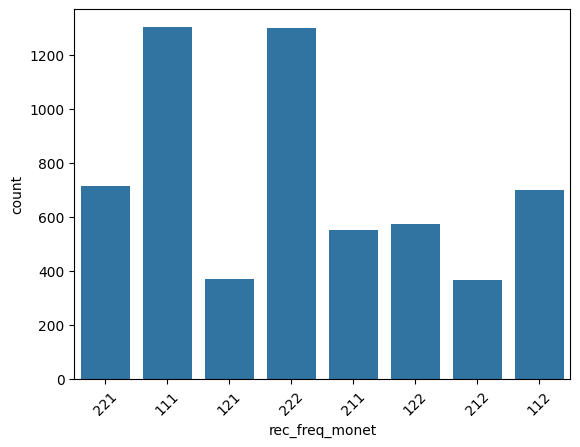

In [8]:
all_data.to_csv('rfm.csv')

fig = sns.countplot(x='rec_freq_monet', data=all_data)
fig.set_xticklabels(fig.get_xticklabels(), rotation=45)


/var/folders/gc/100pfd8j49z3b15kddwjy4kw0000gn/T/ipykernel_60475/3646930757.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['centroids'] = fitting


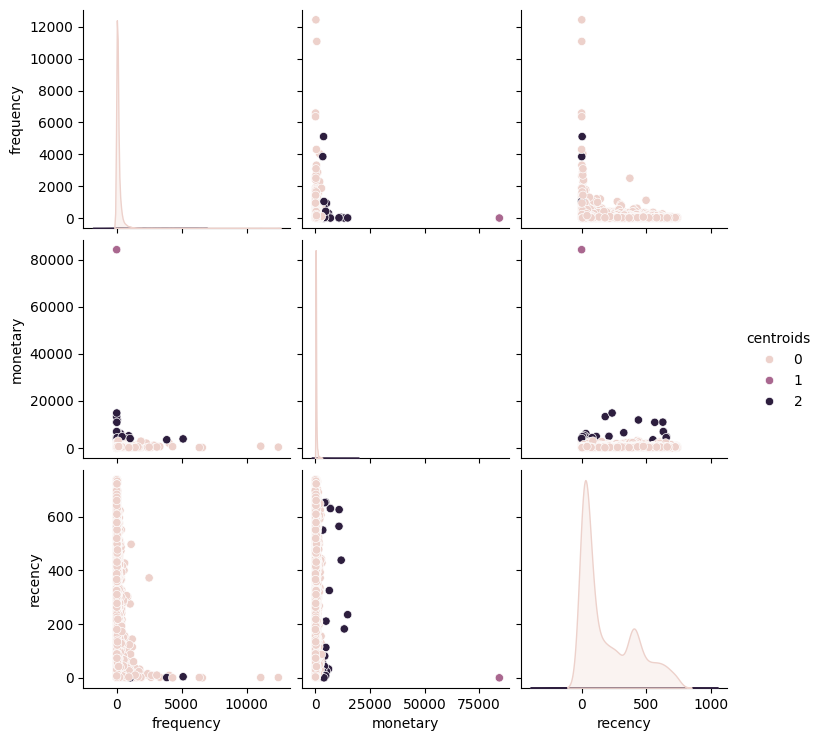

In [11]:
rfm = pd.read_csv('../../Data/MarketingAnalytics/rfm_revised.csv')
X = rfm[['frequency', 'monetary', 'recency']]

km = KMeans(n_clusters=3, n_init=10, max_iter=300, tol=0.0001)
fitting = km.fit_predict(X)
X['centroids'] = fitting

sns.pairplot(data=X, hue='centroids')


Loading Data: Reads the RFM data that includes features for clustering.

K-Means Clustering:

n_clusters=3: Specifies the number of clusters to form.

n_init=10: Number of initializations to perform to ensure convergence.

max_iter=300: Maximum number of iterations for convergence.

tol=0.0001: Tolerance to declare convergence.

fit_predict(): Applies the K-Means algorithm and predicts the cluster for each customer.

Visualization: Uses seaborn's pairplot to visualize the clusters.

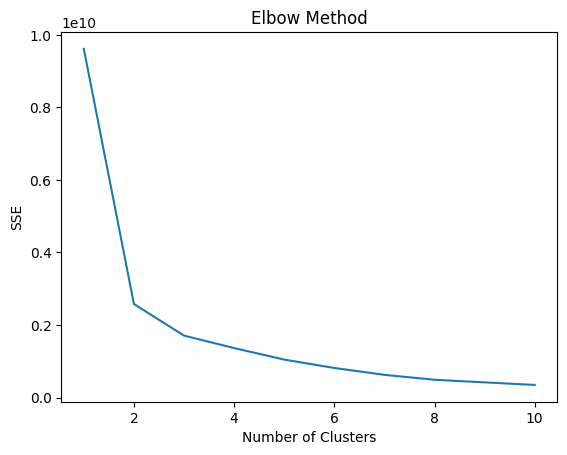

In [10]:
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300, tol=0.0001)
    a = kmeans.fit(X)
    sse.append(a.inertia_)

plt.plot(range(1, 11), sse)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()


Elbow Method: Used to determine the optimal number of clusters by plotting the Sum of Squared Errors (SSE) for different values of k.
SSE: Measures the variance within each cluster. Lower SSE indicates better clustering.
Plotting: Helps visualize where increasing the number of clusters results in diminishing returns (the "elbow").